In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale,StandardScaler
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor

In [2]:
data=pd.read_csv('RealEstate_California.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35389 entries, 0 to 35388
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          35389 non-null  int64  
 1   id                  35389 non-null  object 
 2   stateId             35389 non-null  int64  
 3   countyId            35389 non-null  int64  
 4   cityId              35389 non-null  int64  
 5   country             35389 non-null  object 
 6   datePostedString    35386 non-null  object 
 7   is_bankOwned        35389 non-null  int64  
 8   is_forAuction       35389 non-null  int64  
 9   event               35389 non-null  object 
 10  time                35100 non-null  float64
 11  price               35389 non-null  float64
 12  pricePerSquareFoot  35389 non-null  float64
 13  city                35389 non-null  object 
 14  state               35389 non-null  object 
 15  yearBuilt           35389 non-null  int64  
 16  stre

In [4]:
data=data[['stateId',	'countyId',	'cityId',	'datePostedString',	'is_bankOwned'	,'is_forAuction',	'event',	'time',	'price',	'pricePerSquareFoot',	'yearBuilt',	'zipcode'	,'longitude',	'latitude',	'hasBadGeocode',	'currency',	'livingArea',	'livingAreaValue',	'lotAreaUnits'	,'bathrooms',	'bedrooms',	'buildingArea',	'parking',	'garageSpaces',	'hasGarage',	'levels',	'pool',	'spa',	'isNewConstruction',	'hasPetsAllowed',	'homeType']]
data=data.groupby('event').get_group('Listed for sale')
data=data.groupby('lotAreaUnits').get_group('sqft').drop(['lotAreaUnits'],axis=1)

<Axes: xlabel='time', ylabel='price'>

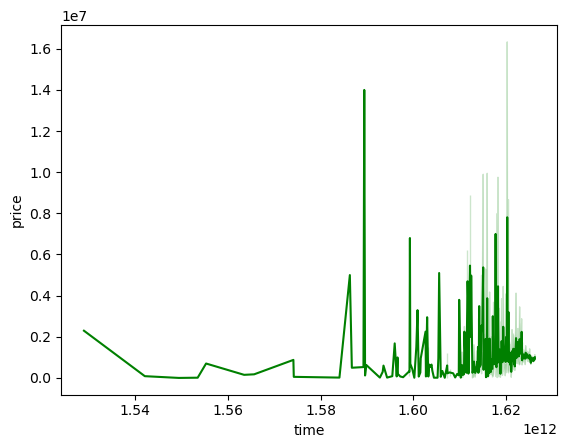

In [5]:
sb.lineplot(data=data,x='time',y='price',color='g')

In [6]:
data['datePostedString']=pd.to_datetime(data['datePostedString'],format='%Y-%m-%d')

In [7]:
data['datePostedString'].apply(lambda x : x.year).unique()

array([2021, 2020, 2019, 2016])

In [8]:
data['month']=data['datePostedString'].apply(lambda x : x.month)
data['year']=data['datePostedString'].apply(lambda x : x.year)


In [9]:
data.drop(['datePostedString','event'],axis=1,inplace=True)

In [10]:
df1=data[['pricePerSquareFoot','livingArea','livingAreaValue','buildingArea']].replace({0:np.nan})
for i in df1.columns:
    data[i]=df1[i]

In [11]:
data.levels.value_counts()

0                                      6511
One                                    4561
Two                                    3010
One Story                               496
Two Story                               407
Three Or More                           336
Multi/Split                             195
One Story-One                            85
Three or More Stories                    70
Two Story-Two                            53
One-Two                                  36
Tri-Level                                29
Three or More Stories-Three Or More      24
Two-Multi/Split                          18
2                                        14
Four                                     12
Two Story-One                             8
Other                                     6
Three                                     6
Two Story-Three Or More                   5
Two-Three Or More                         5
Three Or More-Multi/Split                 5
Three or More Stories-Two       

In [12]:
value=data.levels.replace({'One':1,'0':0,'Two':2,'Two Story':2,"One Story":1,'Three Or More':3})
data.levels=value
selected_index=value[value.astype(str).str.isnumeric()].index
data=data.loc[selected_index,:]
data['levels']=data['levels'].astype('int')

In [13]:
data.drop(['buildingArea','livingAreaValue'],axis=1,inplace=True)

In [14]:
data.livingArea=data.livingArea.fillna(data.livingArea.mean())
data.pricePerSquareFoot=data.pricePerSquareFoot.fillna(data.pricePerSquareFoot.mean())

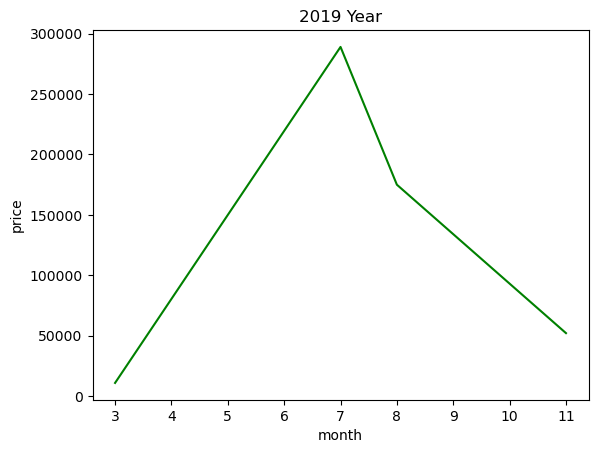

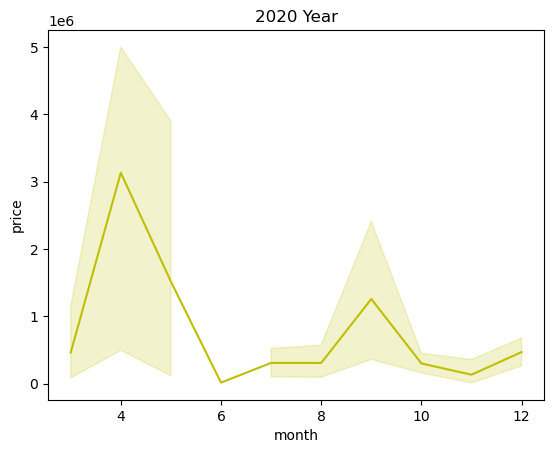

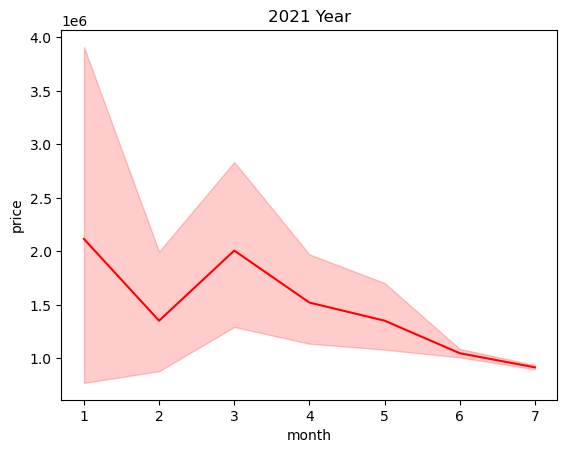

In [16]:
for i in [(2019,'g'),(2020,'y'),(2021,'r')]:
    df2=data.groupby('year').get_group(i[0])
    sb.lineplot(data=df2,x='month',y='price',color=i[1])
    plt.title(f'{i[0]} Year')
    plt.show()

* It Show the prices are increasing over time
* For this case we have the 'time' feature in our dataset so we can drop month and year from our dataset

In [17]:
data.drop(['month','year'],axis=1,inplace=True)

* so the order can be found out is Multi_Family > Single_family > Town_house > Condo > lot

In [21]:
data.homeType.unique()

array(['SINGLE_FAMILY', 'CONDO', 'TOWNHOUSE', 'LOT', 'MULTI_FAMILY'],
      dtype=object)

In [22]:
encoder=OrdinalEncoder(categories=[['MULTI_FAMILY','SINGLE_FAMILY','TOWNHOUSE','CONDO','LOT']])


In [23]:
data['homeType']=encoder.fit_transform(data[['homeType']])

<Axes: xlabel='longitude', ylabel='latitude'>

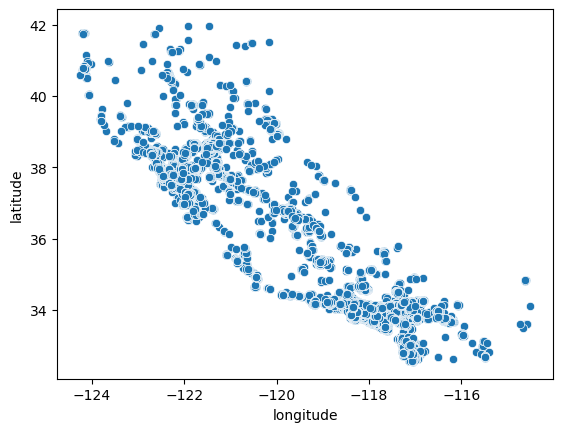

In [24]:
sb.scatterplot(data=data[['longitude','latitude']],x='longitude',y='latitude')

In [25]:
df3=data[['latitude','longitude']]

In [26]:
list1=[]
for i in range(1,10):
    km=KMeans(i)
    km.fit(df3)
    list1.append(km.inertia_)

<Axes: >

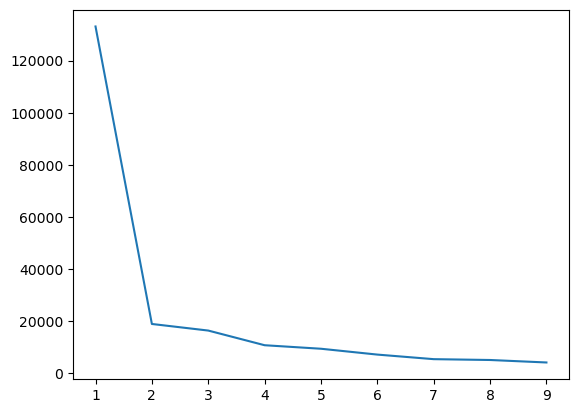

In [27]:
sb.lineplot(x=range(1,10),y=list1)

In [28]:
km=KMeans(2)

In [29]:
df3['region']=data['region']=km.fit_predict(df3)
data.drop(['longitude','latitude'],axis=1,inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

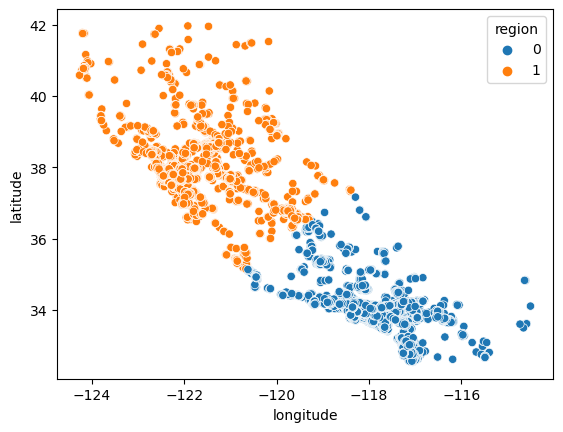

In [30]:
sb.scatterplot(data=df3,x='longitude',y='latitude',hue='region')

<Axes: xlabel='cityId', ylabel='Count'>

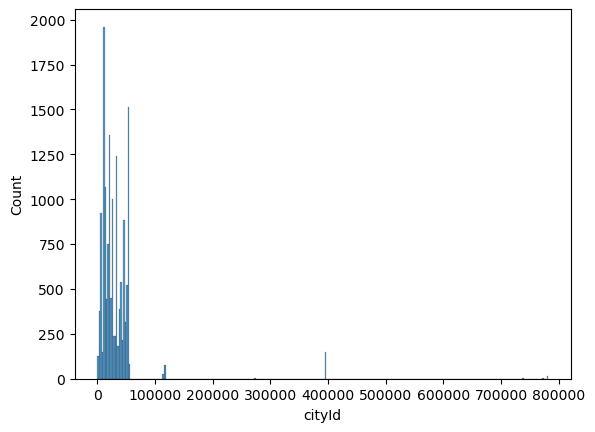

In [31]:
sb.histplot(data['cityId'])

In [32]:
index=np.where(data['cityId']<100000)
data=data.query('cityId<100000')

<Axes: xlabel='cityId', ylabel='Count'>

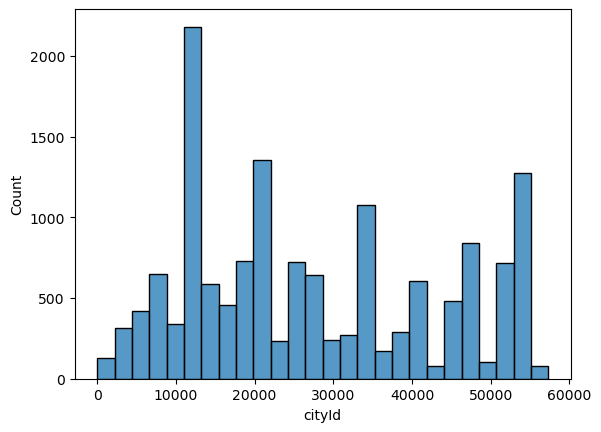

In [33]:
sb.histplot(data['cityId'])

In [34]:
bins=[x for x in range(0,60001,10000)]
data['cityId']=pd.cut(data['cityId'],bins=bins)
city_data=pd.get_dummies(data['cityId'],prefix='cityId').replace({False:0,True:1})
data=data.join(city_data).drop('cityId',axis=1)
data.countyId.nunique()

14797

<Axes: xlabel='countyId', ylabel='Count'>

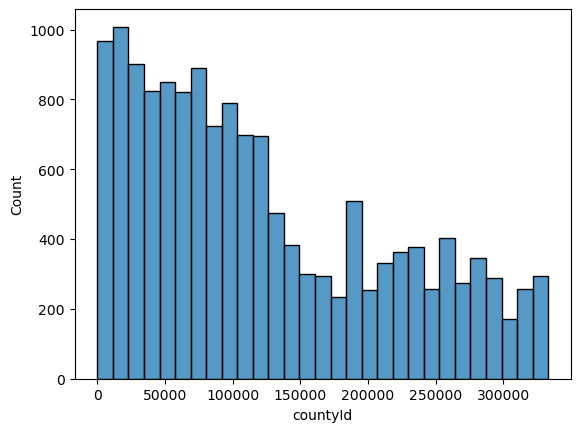

In [35]:
sb.histplot(data['countyId'])

In [36]:
bins=[x for x in range(0,300001,10000)]
data['countyId']=pd.cut(data['countyId'],bins=bins)
county_data=pd.get_dummies(data['countyId'],prefix='countyId').replace({False:0,True:1})
data=data.join(county_data).drop('countyId',axis=1)

In [37]:
data.drop('stateId',axis=1,inplace=True)
data.drop('zipcode',axis=1,inplace=True)
data.drop('currency',axis=1,inplace=True)

In [38]:
data=data.loc[np.sqrt(data['price'])<4000]

In [39]:
ydata=np.sqrt(data.price)
xdata=data.drop('price',axis=1)

In [40]:
scaler=('scale',StandardScaler(),['time','pricePerSquareFoot','livingArea'])
col=ColumnTransformer([scaler])

In [41]:
newdata=col.fit_transform(xdata)
xdata.reset_index(drop=True,inplace=True)
xdata.drop(['time','pricePerSquareFoot','livingArea'],axis=1,inplace=True)
df=pd.DataFrame(newdata,columns=['time','pricePerSquareFoot','livingArea'])
xdata=xdata.join(df)

In [42]:
xtra,xtest,ytra,ytest=train_test_split(xdata,ydata,test_size=0.2)

In [43]:
model=tf.keras.Sequential()

In [44]:
input_size=xtra.shape[1]
output_size=1


In [45]:
model.add(tf.keras.layers.Dense(input_size,activation='relu'))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse',optimizer='adam')
#callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=6)
model.fit(xtra,ytra,validation_data=(xtest,ytest),epochs=200,batch_size=500)

Epoch 1/200
24/24 [==============================] - 0s 3ms/step - loss: 431454.0625 - val_loss: 184953.5156
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 150880.1406 - val_loss: 139668.2188
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 140777.7344 - val_loss: 136555.6562
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 137371.0156 - val_loss: 131414.2812
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 130382.2578 - val_loss: 125453.7031
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 126547.5938 - val_loss: 124196.7969
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 125459.0469 - val_loss: 123456.5469
Epoch 8/200
24/24 [==============================] - 0s 2ms/step - loss: 124776.6953 - val_loss: 123140.5781
Epoch 9/200
24/24 [==============================] - 0s 2ms/step - loss: 124400.5391 - val_loss: 122958.6562
Epoch 10/200
24/24 

24/24 [==============================] - 0s 2ms/step - loss: 76748.2109 - val_loss: 78197.6953
Epoch 77/200
24/24 [==============================] - 0s 1ms/step - loss: 79776.4844 - val_loss: 78027.5938
Epoch 78/200
24/24 [==============================] - 0s 1ms/step - loss: 76765.5391 - val_loss: 76637.0625
Epoch 79/200
24/24 [==============================] - 0s 1ms/step - loss: 75467.4453 - val_loss: 76577.8828
Epoch 80/200
24/24 [==============================] - 0s 1ms/step - loss: 76433.9922 - val_loss: 79874.9141
Epoch 81/200
24/24 [==============================] - 0s 1ms/step - loss: 75463.1641 - val_loss: 77189.9609
Epoch 82/200
24/24 [==============================] - 0s 1ms/step - loss: 74914.0234 - val_loss: 76563.9531
Epoch 83/200
24/24 [==============================] - 0s 1ms/step - loss: 75198.3047 - val_loss: 79347.8516
Epoch 84/200
24/24 [==============================] - 0s 1ms/step - loss: 75540.2969 - val_loss: 76682.6484
Epoch 85/200
24/24 [=====================

24/24 [==============================] - 0s 2ms/step - loss: 69928.9219 - val_loss: 74380.4062
Epoch 152/200
24/24 [==============================] - 0s 1ms/step - loss: 69943.0859 - val_loss: 75406.3047
Epoch 153/200
24/24 [==============================] - 0s 1ms/step - loss: 72251.0859 - val_loss: 85136.1172
Epoch 154/200
24/24 [==============================] - 0s 1ms/step - loss: 74912.4688 - val_loss: 79899.8984
Epoch 155/200
24/24 [==============================] - 0s 1ms/step - loss: 70114.2891 - val_loss: 74950.7656
Epoch 156/200
24/24 [==============================] - 0s 2ms/step - loss: 70217.7500 - val_loss: 73301.5078
Epoch 157/200
24/24 [==============================] - 0s 2ms/step - loss: 69275.0625 - val_loss: 73662.2656
Epoch 158/200
24/24 [==============================] - 0s 2ms/step - loss: 70131.2344 - val_loss: 73299.2734
Epoch 159/200
24/24 [==============================] - 0s 2ms/step - loss: 70297.2422 - val_loss: 78677.9922
Epoch 160/200
24/24 [============

In [46]:
losses=model.history.history

In [48]:
model2=tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(input_size,activation='relu'))
model2.add(tf.keras.layers.Dropout(0.3))
model2.add(tf.keras.layers.Dense(128,activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(64,activation='relu'))
model2.add(tf.keras.layers.Dropout(0.3))
model2.add(tf.keras.layers.Dense(32,activation='relu'))
model2.add(tf.keras.layers.Dense(1))
model2.compile(loss='mse',optimizer='adam')
#callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=6)
model2.fit(xtra,ytra,validation_data=(xtest,ytest),batch_size=200,epochs=200)

Epoch 1/200
60/60 [==============================] - 0s 2ms/step - loss: 237394.2031 - val_loss: 196164.2969
Epoch 2/200
60/60 [==============================] - 0s 1ms/step - loss: 163182.4531 - val_loss: 243979.2500
Epoch 3/200
60/60 [==============================] - 0s 1ms/step - loss: 153964.4531 - val_loss: 274672.9375
Epoch 4/200
60/60 [==============================] - 0s 1ms/step - loss: 146066.7188 - val_loss: 261208.7969
Epoch 5/200
60/60 [==============================] - 0s 1ms/step - loss: 141048.4688 - val_loss: 259733.4844
Epoch 6/200
60/60 [==============================] - 0s 1ms/step - loss: 139290.2656 - val_loss: 275111.6875
Epoch 7/200
60/60 [==============================] - 0s 1ms/step - loss: 137973.8906 - val_loss: 274182.7500
Epoch 8/200
60/60 [==============================] - 0s 1ms/step - loss: 135888.5938 - val_loss: 296172.4062
Epoch 9/200
60/60 [==============================] - 0s 1ms/step - loss: 136574.1094 - val_loss: 296593.0625
Epoch 10/200
60/60 

Epoch 76/200
60/60 [==============================] - 0s 1ms/step - loss: 85363.6719 - val_loss: 232295.8906
Epoch 77/200
60/60 [==============================] - 0s 1ms/step - loss: 84739.5781 - val_loss: 281932.6250
Epoch 78/200
60/60 [==============================] - 0s 1ms/step - loss: 84381.9453 - val_loss: 292816.0312
Epoch 79/200
60/60 [==============================] - 0s 1ms/step - loss: 84532.2969 - val_loss: 282615.0938
Epoch 80/200
60/60 [==============================] - 0s 1ms/step - loss: 86344.0625 - val_loss: 269907.3125
Epoch 81/200
60/60 [==============================] - 0s 1ms/step - loss: 84880.4766 - val_loss: 245499.2969
Epoch 82/200
60/60 [==============================] - 0s 1ms/step - loss: 82326.1562 - val_loss: 268274.7812
Epoch 83/200
60/60 [==============================] - 0s 1ms/step - loss: 84095.8281 - val_loss: 288549.0625
Epoch 84/200
60/60 [==============================] - 0s 1ms/step - loss: 85468.9766 - val_loss: 231381.0625
Epoch 85/200
60/60 

60/60 [==============================] - 0s 1ms/step - loss: 78721.6484 - val_loss: 292333.7500
Epoch 151/200
60/60 [==============================] - 0s 1ms/step - loss: 78152.2969 - val_loss: 265431.6562
Epoch 152/200
60/60 [==============================] - 0s 1ms/step - loss: 79193.3672 - val_loss: 270586.9688
Epoch 153/200
60/60 [==============================] - 0s 1ms/step - loss: 78449.0312 - val_loss: 271299.4688
Epoch 154/200
60/60 [==============================] - 0s 1ms/step - loss: 78255.1250 - val_loss: 259697.3125
Epoch 155/200
60/60 [==============================] - 0s 1ms/step - loss: 79145.2109 - val_loss: 263993.9375
Epoch 156/200
60/60 [==============================] - 0s 1ms/step - loss: 78460.5156 - val_loss: 264201.1562
Epoch 157/200
60/60 [==============================] - 0s 1ms/step - loss: 76602.6797 - val_loss: 293015.6875
Epoch 158/200
60/60 [==============================] - 0s 1ms/step - loss: 77600.0078 - val_loss: 291147.8750
Epoch 159/200
60/60 [===

In [49]:
losses=model.history.history

In [57]:
model1=LinearRegression()
model2=SVR()
model3=xgb.XGBRegressor()
model4=KNeighborsRegressor()
model5=DecisionTreeRegressor()
model6=BaggingRegressor()
model7=RandomForestRegressor()
model8=AdaBoostRegressor()

In [51]:
xtra=xtra.values
xtest=xtest.values
ytra=ytra.values
ytest=ytest.values